In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers

     |████████████████████████████████| 1.3MB 14.4MB/s 
     |████████████████████████████████| 1.1MB 56.1MB/s 
     |████████████████████████████████| 2.9MB 51.3MB/s 
     |████████████████████████████████| 890kB 65.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=dd0e02750fa0d03553f1429d6d82d47c52079ae901d1627ffb5db8d6ca8740e3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup,BertForSequenceClassification
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [ ]:
RANDOM_SEED = 6
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
df = pd.read_csv("/content/drive/My Drive/DAEN-690/junerussia.csv")
df.head()

,Tweet_text,Region
0,Кремль прокомментировал дело журналиста Голуно...,Russia
1,«Появление женщины в такое время и то на прямо...,Russia
2,Наши люди в смузичную на гироскутерах не ездят!,Russia
3,"RT @vzglyad: То, что сделала Соболь с Симоньян...",Russia
4,"@WERA1OMSK Агаа, я помню. Я в Боровом был в 20...",Russia


In [ ]:
df.shape

(24318, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24318 entries, 0 to 24317
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Tweet_text  24318 non-null  object
 1   Region      24318 non-null  object
dtypes: object(2)
memory usage: 380.1+ KB


In [ ]:
print(df.isnull().sum())

Tweet_text    0
Region        0
dtype: int64


In [ ]:
from collections import Counter
print(Counter(df['Region'].values))

Counter({'Russia': 12159, 'Others': 12159})


In [ ]:
df = df.sample(frac=1, random_state = 24).reset_index(drop=True)

In [ ]:
df.head()

,Tweet_text,Region
0,С прошлого года переобучение по областной прог...,Russia
1,Когда выехал с родителями в долгую поездку и ч...,Others
2,слухаю кароч)),Others
3,Все дело в мгновении. Оно определяет жизнь. \n...,Russia
4,"иногда мне становится плохо от того, ЧТО ЕСТЬ ...",Others


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Countries')

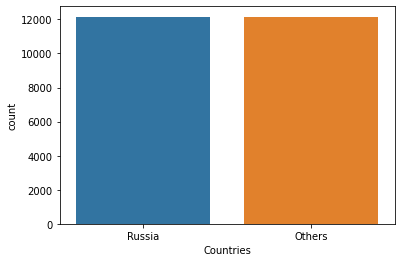

In [ ]:
sns.countplot(df.Region)
plt.xlabel('Countries')

In [ ]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'Region'. 
df['Region']= label_encoder.fit_transform(df['Region']) 
  
df['Region'].unique()

array([1, 0])

In [ ]:
df.head()

,Tweet_text,Region
0,С прошлого года переобучение по областной прог...,1
1,Когда выехал с родителями в долгую поездку и ч...,0
2,слухаю кароч)),0
3,Все дело в мгновении. Оно определяет жизнь. \n...,1
4,"иногда мне становится плохо от того, ЧТО ЕСТЬ ...",0


In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188, 2005, 1016, 3134, 1012]


In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188,
        2005, 1016, 3134, 1012,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# Measure how long it takes to calculate length of tokens.
t0 = time.time()
token_lens = []
for txt in df.Tweet_text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

training_time = format_time(time.time() - t0)
print(" Time taken to calculate length: {:}".format(training_time))

 Time taken to calculate length: 0:00:15


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


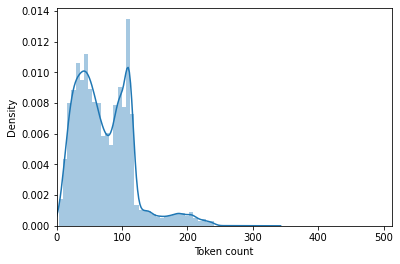

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 128

In [ ]:
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [ ]:
len(df_train), len(df_test),len(df_val)

(21886, 1216, 1216)

In [ ]:
df.shape

(24318, 2)

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.Tweet_text.to_numpy(),
    targets=df.Region.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(2)
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 128])
torch.Size([16, 128])


In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4396, 0.5604],
        [0.4774, 0.5226],
        [0.4989, 0.5011],
        [0.5249, 0.4751],
        [0.4219, 0.5781],
        [0.6457, 0.3543],
        [0.4832, 0.5168],
        [0.4174, 0.5826],
        [0.5543, 0.4457],
        [0.5334, 0.4666],
        [0.6104, 0.3896],
        [0.6275, 0.3725],
        [0.6031, 0.3969],
        [0.4138, 0.5862],
        [0.4765, 0.5235],
        [0.4468, 0.5532]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [ ]:
EPOCHS = 3
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
# Measure the total training time for the whole run.
total_t0 = time.time()

history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

# Measure how long the training epoch takes.
  t0 = time.time()

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
# Measure how long this epoch took.
  training_time = format_time(time.time() - t0)
  print("  Training epcoh took: {:}".format(training_time))
  print(f'Train loss {train_loss} accuracy {train_acc}')

  print("")
  print("Running Validation...")

  t0 = time.time()
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  # Measure how long the validation run took.
  validation_time = format_time(time.time() - t0)
  print("  Validation took: {:}".format(validation_time))
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state1.bin')
    best_accuracy = val_acc

Epoch 1/3
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

  Training epcoh took: 0:05:02
Train loss 0.4957752759399557 accuracy 0.7571049986292607

Running Validation...


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

  Validation took: 0:00:05
Val   loss 0.4392065962678508 accuracy 0.8067434210526315

Epoch 2/3
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

  Training epcoh took: 0:05:02
Train loss 0.3705240103105704 accuracy 0.8404916384903591

Running Validation...


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

  Validation took: 0:00:05
Val   loss 0.4338036863819549 accuracy 0.825657894736842

Epoch 3/3
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

  Training epcoh took: 0:05:02
Train loss 0.30076623706648137 accuracy 0.8771360687197295

Running Validation...


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

  Validation took: 0:00:05
Val   loss 0.44140460106887314 accuracy 0.8297697368421052



In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

0.8231907894736842

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

In [ ]:
class_names = ['Others','Russia']

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      Others       0.83      0.81      0.82       616
      Russia       0.81      0.83      0.82       600

    accuracy                           0.82      1216
   macro avg       0.82      0.82      0.82      1216
weighted avg       0.82      0.82      0.82      1216



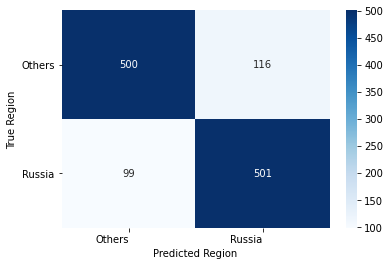

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha='right')
  plt.ylabel('True Region')
  plt.xlabel('Predicted Region');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm,index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
import pandas as pd
df_sample = pd.read_csv("/content/drive/My Drive/DAEN-690/Testing_July_Others_Russia.csv")

In [ ]:
df_sample.head()

,Unnamed: 0,Tweet_text,Region
0,18,"RT @drsy10WSbjZ3Sho: НУ ЧЁ ПАЦАНЫ, НОВОСТИ С К...",Others
1,140,@fuckterprise ой блин я забыла что обещала теб...,Others
2,251,"Как правильно спать, что такое первичные грави...",Others
3,382,RT @bonbon_gi: доброе утро только русскоговоря...,Others
4,966,"Блять мне даже понравилась эта писанина,удивит...",Others


In [ ]:
df_sample.shape

(114416, 3)

In [ ]:
print(df_sample.isnull().sum())

Unnamed: 0    0
Tweet_text    0
Region        0
dtype: int64


In [ ]:
df_sample.columns

Index(['Unnamed: 0', 'Tweet_text', 'Region'], dtype='object')

In [ ]:
def to_sentiment(rating):
  rating = str(rating)
  if rating == 'Others':
    return 0

df_sample['Region'] = df_sample.Region.apply(to_sentiment)

In [ ]:
df_sample.head()

,Unnamed: 0,Tweet_text,Region
0,18,"RT @drsy10WSbjZ3Sho: НУ ЧЁ ПАЦАНЫ, НОВОСТИ С К...",0
1,140,@fuckterprise ой блин я забыла что обещала теб...,0
2,251,"Как правильно спать, что такое первичные грави...",0
3,382,RT @bonbon_gi: доброе утро только русскоговоря...,0
4,966,"Блять мне даже понравилась эта писанина,удивит...",0


In [ ]:
df_sample.shape

(114416, 3)

In [ ]:
df_sample.drop(['Unnamed: 0'],inplace=True,axis=1)

In [ ]:
df_sample.head()

,Tweet_text,Region
0,"RT @drsy10WSbjZ3Sho: НУ ЧЁ ПАЦАНЫ, НОВОСТИ С К...",0
1,@fuckterprise ой блин я забыла что обещала теб...,0
2,"Как правильно спать, что такое первичные грави...",0
3,RT @bonbon_gi: доброе утро только русскоговоря...,0
4,"Блять мне даже понравилась эта писанина,удивит...",0


In [ ]:
sample_data_loader = create_data_loader(df_sample, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  sample_data_loader
)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

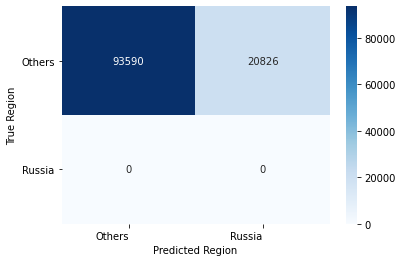

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=0, ha='right')
  plt.ylabel('True Region')
  plt.xlabel('Predicted Region');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm,index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
test_acc, _ = eval_model(
  model,
  sample_data_loader,
  loss_fn,
  device,
  len(df_sample)
)
test_acc.item()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

0.8179800027968116

In [ ]:
sample_df = pd.DataFrame([y_review_texts[i], y_test[i].item(), y_pred[i].item()] for i in range(len(y_test)))

In [ ]:
sample_df.head()

,0,1,2
0,"RT @drsy10WSbjZ3Sho: НУ ЧЁ ПАЦАНЫ, НОВОСТИ С К...",0,0
1,@fuckterprise ой блин я забыла что обещала теб...,0,0
2,"Как правильно спать, что такое первичные грави...",0,0
3,RT @bonbon_gi: доброе утро только русскоговоря...,0,0
4,"Блять мне даже понравилась эта писанина,удивит...",0,0


In [ ]:
sample_df.columns=['Tweet_text','Region','Predicted_Region']

In [ ]:
sample_df.shape

(114416, 3)

In [ ]:
sample_df.head()

,Tweet_text,Region,Predicted_Region
0,"RT @drsy10WSbjZ3Sho: НУ ЧЁ ПАЦАНЫ, НОВОСТИ С К...",0,0
1,@fuckterprise ой блин я забыла что обещала теб...,0,0
2,"Как правильно спать, что такое первичные грави...",0,0
3,RT @bonbon_gi: доброе утро только русскоговоря...,0,0
4,"Блять мне даже понравилась эта писанина,удивит...",0,0


In [ ]:
col = pd.read_csv("/content/drive/My Drive/DAEN-690/columnattachment.csv")

In [ ]:
col.head()

,Unnamed: 0,Screen_Name
0,18,mne_to_netb
1,140,jufdary
2,251,Indicator_ru
3,382,pizza_with_hone
4,966,Dasha_Savina21


In [ ]:
screenname = col["Screen_Name"]

In [ ]:
sample_df = sample_df.join(screenname)

In [ ]:
sample_df.head()

,Tweet_text,Region,Predicted_Region,Screen_Name
0,"RT @drsy10WSbjZ3Sho: НУ ЧЁ ПАЦАНЫ, НОВОСТИ С К...",0,0,mne_to_netb
1,@fuckterprise ой блин я забыла что обещала теб...,0,0,jufdary
2,"Как правильно спать, что такое первичные грави...",0,0,Indicator_ru
3,RT @bonbon_gi: доброе утро только русскоговоря...,0,0,pizza_with_hone
4,"Блять мне даже понравилась эта писанина,удивит...",0,0,Dasha_Savina21


In [ ]:
sample_df.to_csv('sample-russia.csv')